In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading and cleaning the data

For the data on the cyclists and pedestrians, there is a separate Excel file for each month so we need to read them one by one and then concatenate them.

In [2]:
all_files = glob.glob('Pirita/*.xls')

list_of_dfs = []

for filename in all_files:
    df = pd.read_excel(filename, index_col=0)
    df = df.transpose()
    list_of_dfs.append(df)
    
df_pirita = pd.concat(list_of_dfs, axis=0, ignore_index=False, sort=False)

In [3]:
df_pirita.head(3)

,Laikapstākļu informācija,pedestrians: from center,pedestrians: to center,cyclists: from center,cyclists: to center
2018-07-01,NaN,466,492,647,636
2018-07-02,NaN,323,268,450,463
2018-07-03,NaN,292,245,539,409


The first column contains info on the weather but since it is incomplete and not detailed enough then I'll just delete it. Besides, I'll join the weather data to this data frame later anyways.

The rest of the columns contain the number of cyclists and pedestrians that either moved towards the city centre or away from it.

In [4]:
df_pirita.drop(columns=[df_pirita.columns[0]], inplace=True)

I'll also shorten the names of the rest of the columns so that it'll be easier to use them.

In [5]:
df_pirita.rename(columns={'pedestrians: from center':'ped_from_c',
                          'pedestrians: to center':'ped_to_c',
                          'cyclists: from center':'cyc_from_c',
                          'cyclists: to center':'cyc_to_c'}, inplace=True)

I'll also correct the datatypes.

In [6]:
for col in df_pirita.columns:
    df_pirita[col] = df_pirita[col].astype(int)

In [7]:
df_pirita.index = pd.to_datetime(df_pirita.index)
df_pirita.sort_index(inplace=True)

print(len(df_pirita))
df_pirita.head(3)

700


,ped_from_c,ped_to_c,cyc_from_c,cyc_to_c
2018-04-01,261,252,583,331
2018-04-02,293,261,405,349
2018-04-03,261,252,418,349


Now let's have a look at the cyclists' and pedestrians data and whether the number on to and from the city centre differ a lot.

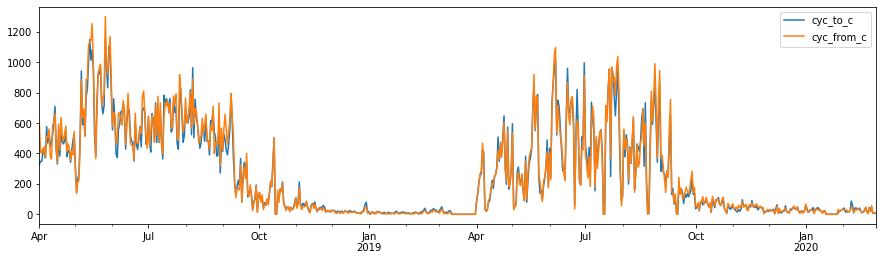

In [8]:
df_pirita[['cyc_to_c', 'cyc_from_c']].plot(kind='line', figsize=(15,4))
plt.show()

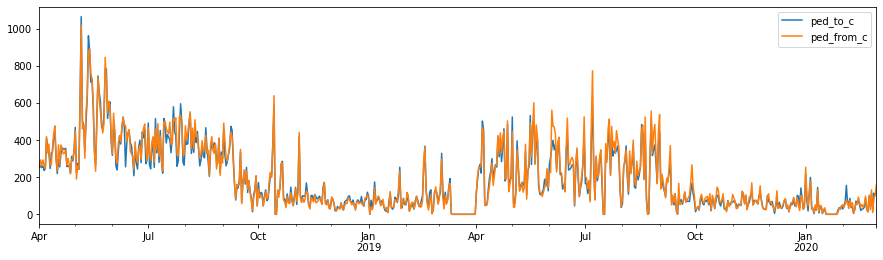

In [9]:
df_pirita[['ped_to_c', 'ped_from_c']].plot(kind='line', figsize=(15,4))
plt.show()

There seem to be some periods (April 2019 and January 2020) where the numbers are zeroes. It's probably due to some errors or maintenance or something. I'll just remove those data points form the data.

In [10]:
df_pirita = df_pirita.loc[(df_pirita['ped_from_c']>0)&(df_pirita['ped_to_c']>0)&
                          (df_pirita['cyc_from_c']>0)&(df_pirita['cyc_to_c']>0)]

Also, the "to" and "from" data for both cyclists and pedestrians seem to be very similar for each day so in order to make things easier, I'll just take an average of them and use that in the analysis.

In [11]:
df_pirita['cyc'] = (df_pirita['cyc_to_c'] + df_pirita['cyc_from_c']) / 2
df_pirita['ped'] = (df_pirita['ped_to_c'] + df_pirita['ped_from_c']) / 2
df_pirita.drop(columns=['ped_from_c', 'ped_to_c', 'cyc_from_c', 'cyc_to_c'], inplace=True)

In [12]:
df_pirita.head(3)

,cyc,ped
2018-04-01,457.0,256.5
2018-04-02,377.0,277.0
2018-04-03,383.5,256.5


# Collecting the weather data

In [13]:
import requests
from bs4 import BeautifulSoup

Next, I need to collect the daily weather data since I didn't find a place anywhere where I could just download it. I'm using the Estonian Weather Service homepage for this.

In [14]:
headers = requests.utils.default_headers()
headers.update({'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})
url = 'https://www.ilmateenistus.ee/ilm/ilmavaatlused/vaatlusandmed/oopaevaandmed/?filter[maxDate]=01.04.2020&filter[minDate]=30.01.2004&filter[date]='

First, I create an empty list where I collect all the data frames where each of them has the daily weather data. I'll also create a list of all the dates for which I need the weather data.

In [15]:
list_of_dfs = []
dates = pd.to_datetime(df_pirita.index).strftime('%d.%m.%Y').to_list()

Then for each date, I open the link that has the weather data, look for the table tag in the HTML which contains the weather data, convert that table to a data frame and finally append it to the data frames list. After collecting all the data, I concatenate all the daily data into one data frame.

In [16]:
for date in dates:
    req = requests.get(url+date, headers)
    soup = BeautifulSoup(req.content, 'html.parser')
    
    table = soup.find_all('table')
    df = pd.read_html(str(table), decimal=',', thousands='.')[0] # table uses ',' for decimal
    df['date'] = date
    
    list_of_dfs.append(df)

df_weather = pd.concat(list_of_dfs, axis=0, ignore_index=False, sort=False)

In [17]:
df_weather.head()

Jaam Õhutemperatuur (°C)            \
        Jaam            keskmine  max  min   
0  Heltermaa                 0.5  2.3 -2.8   
1     Jõgeva                 0.6  2.0 -0.8   
2      Jõhvi                -0.6  2.7 -4.9   
3      Kihnu                 0.7  2.7 -1.9   
4      Kunda                -0.8  2.6 -5.3   

  Maapinna minimaalne temperatuur (°C)  \
  Maapinna minimaalne temperatuur (°C)   
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

  Minimaalne temperatuur 2cm kõrgusel maapinnast (°C)  \
  Minimaalne temperatuur 2cm kõrgusel maapinnast (°C)   
0                                                NaN    
1                                               -0.3    
2                                                NaN    
3                                                NaN    
4                                                NaN    

  Suhteline õhuniiskus (%)       Tuule kiirus (m/s)       Sademed (mm)  \
                  keskmine   min           keskmine   max Sademed (mm)   
0                     82.0  77.0                2.5   8.6          0.0   
1                     80.0  73.0                3.5  11.3          0.0   
2                     81.0  67.0                2.9  10.5          0.0   
3                     81.0  72.0                3.8  11.6          0.0   
4                     83.0  72.0                4.5  13.5          0.0   

  Päikesepaiste kestus (h)        date  
  Päikesepaiste kestus (h)              
0                      NaN  01.04.2018  
1                      3.0  01.04.2018  
2                      6.8  01.04.2018  
3                      NaN  01.04.2018  
4                      NaN  01.04.2018

Renaming the columns.

In [18]:
df_weather.columns = ['station', 'temp_avg', 'temp_max', 'temp_min', 'temp_min_ground',
                      'temp_min_2cm_from_ground',  'humidity_avg', 'humidity_min', 'wind_avg', 
                      'wind_max', 'precipitation', 'sun_h', 'date']

Also, I'll write the data into a CSV file so that I don't have to request it again if I close this notebook or something.

In [19]:
df_weather.to_csv('df_weather.csv', index=False)

In [20]:
df_weather = pd.read_csv('df_weather.csv')

In [21]:
df_weather.head(3)

,station,temp_avg,temp_max,temp_min,temp_min_ground,temp_min_2cm_from_ground,humidity_avg,humidity_min,wind_avg,wind_max,precipitation,sun_h,date
0,Heltermaa,0.5,2.3,-2.8,NaN,NaN,82.0,77.0,2.5,8.6,0.0,NaN,01.04.2018
1,Jõgeva,0.6,2.0,-0.8,NaN,-0.3,80.0,73.0,3.5,11.3,0.0,3.0,01.04.2018
2,Jõhvi,-0.6,2.7,-4.9,NaN,NaN,81.0,67.0,2.9,10.5,0.0,6.8,01.04.2018


Since I only need weather info on Tallinn, I'll keep only that. Also, I don't think I need all the columns so I'll pick only some of them.

In [22]:
df_weather_tln = df_weather.copy()
df_weather_tln = df_weather_tln.loc[df_weather['station']=='Tallinn-Harku']

df_weather_tln['date'] = pd.to_datetime(df_weather_tln['date'], format='%d.%m.%Y')
df_weather_tln = df_weather_tln.set_index('date')

df_weather_tln = df_weather_tln[['temp_avg', 'wind_avg', 'precipitation', 'humidity_avg', 'sun_h']]

df_weather_tln.head()

,temp_avg,wind_avg,precipitation,humidity_avg,sun_h
date,,,,,
2018-04-01,-0.1,3.5,0.0,79.0,3.6
2018-04-02,-0.2,4.4,15.8,97.0,0.0
2018-04-03,0.0,3.7,0.5,74.0,10.0
2018-04-04,0.9,3.6,1.8,78.0,5.1
2018-04-05,7.9,2.8,1.1,91.0,4.0


# Merge Pirita data with weather data

And the last step before the regression analysis is to merge the cyclists' and pedestrians' data with the weather data.

In [23]:
df = df_pirita.merge(df_weather_tln, left_index=True, right_index=True)
df.head(3)

,cyc,ped,temp_avg,wind_avg,precipitation,humidity_avg,sun_h
2018-04-01,457.0,256.5,-0.1,3.5,0.0,79.0,3.6
2018-04-02,377.0,277.0,-0.2,4.4,15.8,97.0,0.0
2018-04-03,383.5,256.5,0.0,3.7,0.5,74.0,10.0


In [24]:
df.columns = [x.replace('_avg', '') for x in df.columns]

Just in case let's check that we don't have any nulls in any of the columns.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 662 entries, 2018-04-01 to 2020-02-29
Data columns (total 7 columns):
cyc              662 non-null float64
ped              662 non-null float64
temp             662 non-null float64
wind             662 non-null float64
precipitation    662 non-null float64
humidity         662 non-null float64
sun_h            662 non-null float64
dtypes: float64(7)
memory usage: 41.4 KB


# Regression

## Cyclists

Let's stars with the cyclists' data.

In [26]:
import statsmodels.api as sm
from scipy import stats
import sklearn.metrics as metrics

I'll create a separate data frame for cyclists' data.

In [27]:
df_cyc = df.copy()
df_cyc = df_cyc.drop(columns=['ped'])

Let's run the regression analysis.

In [28]:
features = ['temp', 'wind', 'precipitation', 'humidity', 'sun_h']
label = 'cyc'
X = df_cyc[features]
y = df_cyc[label]
X = sm.add_constant(X)

model_cyc = sm.OLS(y, X).fit()
predictions = model_cyc.predict(X)

print('t-critical:',round(stats.t.ppf(1-0.025, model_cyc.df_resid),4))

model_cyc.summary()

t-critical: 1.9636


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cyc   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     486.9
Date:                Sun, 26 Apr 2020   Prob (F-statistic):          5.19e-218
Time:                        21:18:32   Log-Likelihood:                -4178.8
No. Observations:                 662   AIC:                             8370.
Df Residuals:                     656   BIC:                             8396.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           279.6783     61.094      4.578      0.000     159.716     399.641
temp             18.2186      0.877     20.773      0.000      16.496      19.941
wind            -26.6603      4.867     -5.477      0.000     -36.218     -17.103
precipitation    -3.7162      1.534     -2.423      0.016      -6.728      -0.704
humidity         -2.2490      0.626     -3.590      0.000      -3.479      -1.019
sun_h            18.6947      1.774     10.540      0.000      15.212      22.178
==============================================================================
Omnibus:                       39.129   Durbin-Watson:                   0.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.158
Skew:                           0.435   Prob(JB):                     1.17e-14
Kurtosis:                       4.253   Cond. No.                         938.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It looks like all the independent variables are significant since the t-statistics are all greater than t-critical (1.936) and the p-values are all less than 0.05.

Let's now calculate the expected values of the dependent variable (the number of cyclists for each day).

In [29]:
params = model_cyc.params.to_dict()
params

{'const': 279.6782587136282,
 'temp': 18.218580944259404,
 'wind': -26.66030491190658,
 'precipitation': -3.7161798286926158,
 'humidity': -2.2490378660426114,
 'sun_h': 18.694683662722586}

In [30]:
df_cyc['cyc_prediction'] = params['const'] + \
    params['temp']*df_cyc['temp'] + \
    params['wind']*df_cyc['wind'] + \
    params['precipitation']*df_cyc['precipitation'] + \
    params['humidity']*df_cyc['humidity'] + \
    params['sun_h']*df_cyc['sun_h']

Let's now calculate Mean Square Error (RMSE) to see how accurate the predicted values are compared to actual values. RMSE is basically a standard deviation of the residuals (predicted minus the actual value) so the smaller the number the better.

In [31]:
actual = df_cyc['cyc']
predict = df_cyc['cyc_prediction']

print('Mean:', actual.mean().round(2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(actual, predict)).round(2)) # 133.4

Mean: 279.34
RMSE: 133.4


Then let's do a bit of residual analysis where I calculate the z-score for each residual and remove all data points where the z-score is more than 2 (which means that those data points are outliers).

In [32]:
df_cyc['residual'] = df_cyc['cyc'] - df_cyc['cyc_prediction']

df_cyc['z_score'] = stats.zscore(df_cyc['residual'])

print('# of data points to be excluded:',
      len(df_cyc.loc[abs(df_cyc['z_score'])>2]))

# of data points to be excluded: 35


In [33]:
df_cyc = df_cyc.loc[abs(df_cyc['z_score'])<2]

Let's now run the regression analysis once more after we've excluded the outliers.

In [34]:
features = ['temp', 'wind', 'precipitation', 'humidity', 'sun_h']
label = 'cyc'
X = df_cyc[features]
y = df_cyc[label]
X = sm.add_constant(X)

model_cyc = sm.OLS(y, X).fit()
predictions = model_cyc.predict(X)

print('t-critical:',round(stats.t.ppf(1-0.025, model_cyc.df_resid),4))

model_cyc.summary()

t-critical: 1.9638


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cyc   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     659.8
Date:                Sun, 26 Apr 2020   Prob (F-statistic):          1.10e-245
Time:                        21:18:32   Log-Likelihood:                -3820.4
No. Observations:                 627   AIC:                             7653.
Df Residuals:                     621   BIC:                             7679.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           176.7007     51.148      3.455      0.001      76.257     277.145
temp             18.5052      0.715     25.889      0.000      17.101      19.909
wind            -22.4854      4.000     -5.622      0.000     -30.340     -14.631
precipitation    -4.9149      1.297     -3.789      0.000      -7.462      -2.368
humidity         -1.2596      0.526     -2.394      0.017      -2.293      -0.226
sun_h            19.0862      1.474     12.947      0.000      16.191      21.981
==============================================================================
Omnibus:                       10.160   Durbin-Watson:                   0.931
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.138
Skew:                           0.286   Prob(JB):                      0.00629
Kurtosis:                       2.752   Cond. No.                         957.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared has increased from 0.788 to 0.842 which means that the model is able to explain more of the variance compared to the previous model. Also, all the independent variables are still significant so no need to exclude any of them from the model.

Let's now make new predictions of the dependent variable based on the coefficients from the updated model. Then let's calculate the new RMSE to see if the new model is more accurate.

In [35]:
params = model_cyc.params.to_dict()
params

{'const': 176.7007455792281,
 'temp': 18.50518144885518,
 'wind': -22.485368134739442,
 'precipitation': -4.914893062075229,
 'humidity': -1.2595808729361664,
 'sun_h': 19.086217110975547}

In [36]:
df_cyc['cyc_prediction'] = params['const'] + \
    params['temp']*df_cyc['temp'] + \
    params['wind']*df_cyc['wind'] + \
    params['precipitation']*df_cyc['precipitation'] + \
    params['humidity']*df_cyc['humidity'] + \
    params['sun_h']*df_cyc['sun_h']

In [37]:
actual = df_cyc['cyc']
predict = df_cyc['cyc_prediction']

print('Mean:', actual.mean().round(2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(actual, predict)).round(2)) # 107.14

Mean: 258.44
RMSE: 107.14


The RMSE has come down from 133.4 to 107.14 which means it's an improvement.

Let's also visualise the actual and predicted number of cyclists per day.

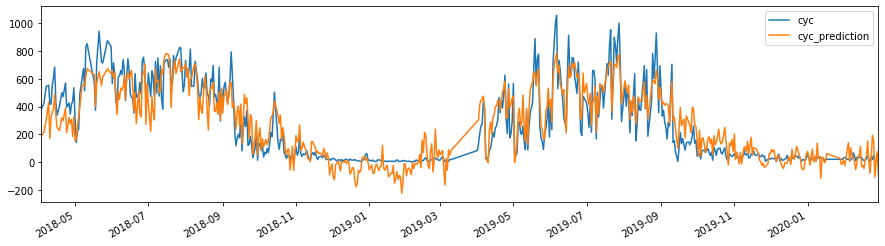

In [38]:
df_cyc[['cyc', 'cyc_prediction']].plot(kind='line', figsize=(15,4))
plt.show()

It seems that the model is not very good at predicting very high and very low values. For some of the days, the model predicts a negative number of cyclists. Let's see how good the model will be if we consider those negative predictions as zeros.

In [39]:
print('number of negative predictions:',
      len(df_cyc.loc[df_cyc['cyc_prediction']<0]))
df_cyc['cyc_prediction'] = np.where(df_cyc['cyc_prediction']<0, 0, 
                                    df_cyc['cyc_prediction'])

number of negative predictions: 106


In [40]:
actual = df_cyc['cyc']
predict = df_cyc['cyc_prediction']

print('Mean:', actual.mean().round(2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(actual, predict)).round(2)) # 102.3

Mean: 258.44
RMSE: 102.3


And the RMSE has now further dropped from 107.14 to 102.3. 

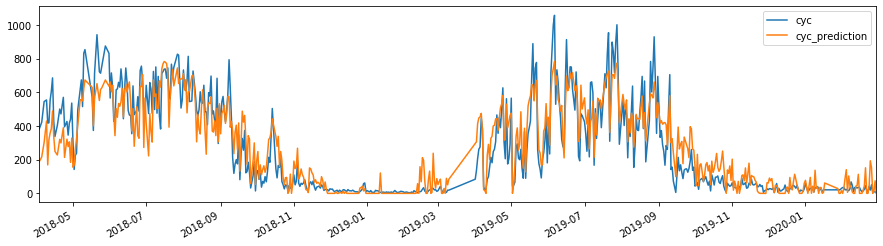

In [41]:
df_cyc[['cyc', 'cyc_prediction']].plot(kind='line', figsize=(15,4))
plt.show()

So the coefficients of the final model to predict the number of cyclists are:

In [42]:
pd.DataFrame(model_cyc.params.round(1), columns=['coeff'])

,coeff
const,176.7
temp,18.5
wind,-22.5
precipitation,-4.9
humidity,-1.3
sun_h,19.1


$$
Y_{cyclists} = 18.5 \ temperature - 22.5 \ wind - 4.9 \ precipitation - 1.3 \ humidity + 19.1 \ sun + 176.7
$$

It looks like temperature, wind and sun affect the number of cyclists the most. Precipitation and humidity don't play that huge role.

## Pedestrians

Now let's do the same process over again with the pedestrians data.

In [43]:
df_ped = df.copy()
df_ped = df_ped.drop(columns=['cyc'])

In [44]:
features = ['temp', 'wind', 'precipitation', 'humidity', 'sun_h']
label = 'ped'
X = df_ped[features]
y = df_ped[label]
X = sm.add_constant(X)

model_ped = sm.OLS(y, X).fit()
predictions = model_ped.predict(X)

print('t-critical:',round(stats.t.ppf(1-0.025, model_ped.df_resid),4))

model_ped.summary()

t-critical: 1.9636


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ped   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     256.6
Date:                Sun, 26 Apr 2020   Prob (F-statistic):          1.02e-151
Time:                        21:18:32   Log-Likelihood:                -3980.1
No. Observations:                 662   AIC:                             7972.
Df Residuals:                     656   BIC:                             7999.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           334.4079     45.254      7.390      0.000     245.547     423.269
temp              7.1334      0.650     10.980      0.000       5.858       8.409
wind            -20.8645      3.605     -5.787      0.000     -27.944     -13.785
precipitation    -2.2131      1.136     -1.948      0.052      -4.444       0.018
humidity         -2.3602      0.464     -5.086      0.000      -3.271      -1.449
sun_h            10.6785      1.314      8.128      0.000       8.099      13.258
==============================================================================
Omnibus:                      181.744   Durbin-Watson:                   0.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              848.810
Skew:                           1.164   Prob(JB):                    4.82e-185
Kurtosis:                       8.035   Cond. No.                         938.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It looks like the variable "precipitation" does not belong to the model since it's t-statistic is not greater than the t-critical, it's p-value is higher than 0.05 and its confidence interval includes 0. So let's exclude it and run the regression again.

In [45]:
features = ['temp', 'wind', 'humidity', 'sun_h']
label = 'ped'
X = df_ped[features]
y = df_ped[label]
X = sm.add_constant(X)

model_ped = sm.OLS(y, X).fit()
predictions = model_ped.predict(X)

print('t-critical:',round(stats.t.ppf(1-0.025, model_ped.df_resid),4))

model_ped.summary()

t-critical: 1.9636


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ped   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     318.4
Date:                Sun, 26 Apr 2020   Prob (F-statistic):          3.54e-152
Time:                        21:18:32   Log-Likelihood:                -3982.0
No. Observations:                 662   AIC:                             7974.
Df Residuals:                     657   BIC:                             7996.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        350.4290     44.595      7.858      0.000     262.863     437.995
temp           6.8971      0.640     10.784      0.000       5.641       8.153
wind         -22.5727      3.505     -6.441      0.000     -29.454     -15.691
humidity      -2.5464      0.455     -5.596      0.000      -3.440      -1.653
sun_h         10.9238      1.311      8.335      0.000       8.350      13.497
==============================================================================
Omnibus:                      177.232   Durbin-Watson:                   0.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              806.902
Skew:                           1.141   Prob(JB):                    6.07e-176
Kurtosis:                       7.904   Cond. No.                         922.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now all the variables look significant so we can proceed with calculating the predicted value of the pedestrians.

In [46]:
params = model_ped.params.to_dict()
params

{'const': 350.4290311103612,
 'temp': 6.897121822307611,
 'wind': -22.57267190678928,
 'humidity': -2.546415597084453,
 'sun_h': 10.923791456331195}

In [47]:
df_ped['ped_prediction'] = params['const'] + \
    params['temp']*df['temp'] + \
    params['wind']*df['wind'] + \
    params['humidity']*df['humidity'] + \
    params['sun_h']*df['sun_h']

Similarly, I'm using the RMSE to assess the accuracy of the model.

In [48]:
actual = df_ped['ped']
predict = df_ped['ped_prediction']

print('Mean:', actual.mean().round(2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(actual, predict)).round(2)) # 99.1

Mean: 204.56
RMSE: 99.1


Now let's calculate the z-scores of the residuals and see which data points should be excluded from the model.

In [49]:
df_ped['residual'] = df_ped['ped'] - df_ped['ped_prediction']

df_ped['z_score'] = stats.zscore(df_ped['residual'])

print('# of data points to be excluded:',
      len(df_ped.loc[abs(df_ped['z_score'])>2]))

# of data points to be excluded: 23


In [50]:
df_ped = df_ped.loc[abs(df_ped['z_score'])<2]

In [51]:
features = ['temp', 'wind', 'humidity', 'sun_h']
label = 'ped'
X = df_ped[features]
y = df_ped[label]
X = sm.add_constant(X)

model_ped = sm.OLS(y, X).fit()
predictions = model_ped.predict(X)

print('t-critical:',round(stats.t.ppf(1-0.025, model_ped.df_resid),4))

model_ped.summary()

t-critical: 1.9637


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ped   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     430.8
Date:                Sun, 26 Apr 2020   Prob (F-statistic):          3.74e-179
Time:                        21:18:32   Log-Likelihood:                -3698.7
No. Observations:                 639   AIC:                             7407.
Df Residuals:                     634   BIC:                             7430.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        327.4943     36.323      9.016      0.000     256.166     398.823
temp           6.9681      0.515     13.523      0.000       5.956       7.980
wind         -22.6614      2.867     -7.904      0.000     -28.292     -17.031
humidity      -2.2918      0.372     -6.163      0.000      -3.022      -1.562
sun_h         10.1441      1.064      9.531      0.000       8.054      12.234
==============================================================================
Omnibus:                        9.878   Durbin-Watson:                   1.068
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.134
Skew:                           0.297   Prob(JB):                      0.00630
Kurtosis:                       2.836   Cond. No.                         929.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared has increased from 0.660 to 0.731. All the variables are still significant. Let's then update the prediction of pedestrians according to the new model.

In [52]:
params = model_ped.params.to_dict()
params

{'const': 327.49434951471636,
 'temp': 6.968075472294397,
 'wind': -22.66137070269732,
 'humidity': -2.2917886082752656,
 'sun_h': 10.144106610391706}

In [53]:
df_ped['ped_prediction'] = params['const'] + \
    params['temp']*df_ped['temp'] + \
    params['wind']*df_ped['wind'] + \
    params['humidity']*df_ped['humidity'] + \
    params['sun_h']*df_ped['sun_h']

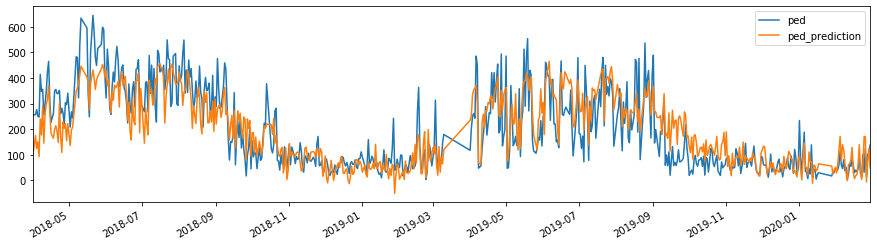

In [54]:
df_ped[['ped', 'ped_prediction']].plot(kind='line', figsize=(15,4))
plt.show()

In [55]:
actual = df_ped['ped']
predict = df_ped['ped_prediction']

print('Mean:', actual.mean().round(2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(actual, predict)).round(2)) # 78.99

Mean: 193.59
RMSE: 78.99


RMSE has also improved from 99.1 to 78.99.

Let's also see how many predictions were negative and then let's correct them to 0.

In [56]:
print('number of negative predictions:',
      len(df_ped.loc[df_ped['ped_prediction']<0]))
df_ped['ped_prediction'] = np.where(df_ped['ped_prediction']<0, 0, 
                                    df_ped['ped_prediction'])

number of negative predictions: 6


In [57]:
actual = df_ped['ped']
predict = df_ped['ped_prediction']

print('Mean:', actual.mean().round(2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(actual, predict)).round(2)) # 78.9

Mean: 193.59
RMSE: 78.9


The RMSE has not improved very much but then again there were not that many negative value predictions.

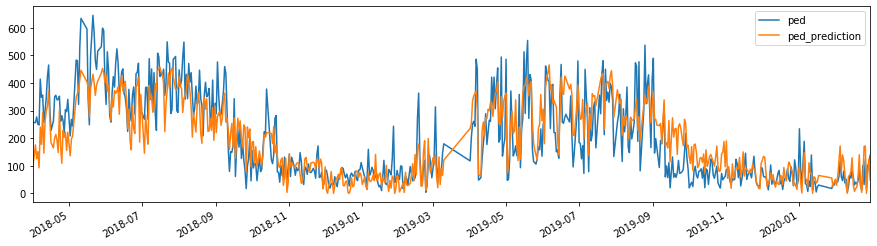

In [58]:
df_ped[['ped', 'ped_prediction']].plot(kind='line', figsize=(15,4))
plt.show()

So the coefficients of the final model to predict the number of pedestrians are:

In [59]:
pd.DataFrame(model_ped.params.round(1), columns=['coeff'])

,coeff
const,327.5
temp,7.0
wind,-22.7
humidity,-2.3
sun_h,10.1


$$
Y_{pedestrians} = 7.0 \ temperature - 22.7 \ wind - 2.3 \ humidity + 10.1 \ sun + 327.5
$$

It looks like wind and sun affect the number of pedestrians the most. Temperature and humidity don't seem to have that much influence.